<a href="https://colab.research.google.com/github/nedokormysh/Stepik_Competitive_DS/blob/week_6/solution_6_4_1_%2B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
!pip install catboost -q
!pip install pytorch-tabnet -q
!pip install optuna -q
!pip install gerrychain -q
# !pip install lightgbm -q
# !pip install xgboost -q

# Загрузка библиотек

In [40]:
from typing import Any
import re

from gerrychain.random import random

import pandas as pd
import numpy as np

import optuna
from optuna.integration import CatBoostPruningCallback, LightGBMPruningCallback, XGBoostPruningCallback
# optuna.logging.set_verbosity(optuna.logging.WARNING)

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
import lightgbm as lgb
from lightgbm import LGBMRegressor, early_stopping, Dataset
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import ElasticNet
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import NuSVR

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import make_pipeline


from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

from torch.utils.data import Dataset, DataLoader
import torch
from torch import nn
import copy

import pickle
import warnings
warnings.simplefilter('ignore')

import os
import platform
import psutil

In [41]:
# фиксируем random state согласно инструкции для optuna
!export PYTHONHASHSEED=0
random.seed(7575)

In [42]:
# print(platform.system(), platform.processor())
# # print(os.uname())
# print('CPU count:', os.cpu_count())
# print('RAM (GB):', psutil.virtual_memory()[0]/1000000000)
# print('RAM memory % used:', psutil.virtual_memory()[2])
# !python -V

# Загрузка данных

In [43]:
PATH_TRAIN = 'https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/quickstart_train.csv'
PATH_TEST = 'https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/quickstart_test.csv'

## Оптимизируем объём памяти.

In [44]:
def reduce_mem_usage(df: pd.DataFrame) -> pd.DataFrame:
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

def import_data(file: str)-> pd.DataFrame:
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df

In [45]:
print('train')
train = import_data(PATH_TRAIN)

print('-' * 80)
print('test')
test = import_data(PATH_TEST)

train
Memory usage of dataframe is 0.30 MB
Memory usage after optimization is: 0.16 MB
Decreased by 47.7%
--------------------------------------------------------------------------------
test
Memory usage of dataframe is 0.23 MB
Memory usage after optimization is: 0.14 MB
Decreased by 40.9%


## Подготовка данных

In [46]:
# инициализируем листы числовых, категориальных, целевых признаков и признаки, которые не потребуются для анализа.
cat_features = ['model', 'car_type', 'fuel_type']
cat_features_indxs = [0, 1, 2]
targets = [#'target_class',
           'target_reg']
features2drop = ['car_id', 'deviation_normal_count', 'target_class']

filtered_features = [i for i in train.columns if (i not in targets and i not in features2drop)]
num_features = [i for i in filtered_features if i not in cat_features]

print(f'\033[1mcat_features:\033[0m {cat_features}, \033[1mamount\033[0m = {len(cat_features)}')
print(f'\033[1mnum_features:\033[0m {num_features}, \033[1mamount\033[0m = {len(num_features)}')
print(f'\033[1mtargets:\033[0m {targets}, \033[1mamount\033[0m = {len(targets)}')

cat_features: ['model', 'car_type', 'fuel_type'], amount = 3
num_features: ['car_rating', 'year_to_start', 'riders', 'year_to_work', 'mean_rating', 'distance_sum', 'rating_min', 'speed_max', 'user_ride_quality_median', 'user_uniq'], amount = 10
targets: ['target_reg'], amount = 1


In [47]:
# Заменим тип данных object на category в категориальных признаках

for col in cat_features:
    train[col] = train[col].astype("category")

for col in cat_features:
    test[col] = test[col].astype("category")

In [48]:
# инициализируем номер случайного состояния, словарь лучших моделей, словарь для результатов
# датасет для формирования результатов
R_S = 7575
n_est = 400
sampler = optuna.samplers.TPESampler(seed=R_S)

bst_mdls = {}
mean_scores = {}

df_sub = pd.DataFrame(test['car_id'])

In [49]:
# получаем разбиение на фичи и целевую переменную
X = train[filtered_features].drop(targets, axis=1, errors="ignore")
y = train["target_reg"]

# разбиение на обучающую и валидационную выборки
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=R_S)

# подготовка тестовых данных
X_sub = test[filtered_features].drop(targets, axis=1, errors="ignore")

## Вспомогательные функции и классы

### Класс для нормализации цифровых признаков

Т.к. catboost может работать с категориальными признаками самостоятельно, то хочу подать dataframe в нашу модель. При этом хочу стандартизировать числовые признаки. (пусть для модели catboost, насколько я понимаю, это и не принципиальное действие). Для этого напишем кастомный класс transformer

In [50]:
class CustomTransformer(TransformerMixin):
    '''
    .. notes::
    Класс трансформации признаков.
    Числовые данные нормализуются или стандартизируются.
    Категориальные признаки не изменяются.
    После трансформаци возвращается датафрейм.
    '''
    def __init__(self,
                 scaler_type: Any=None,
                 cat_feats: list[str]=None,
                 with_mean: bool=True,
                 with_std: bool=True,
                 feature_range: tuple[int, int]=(0, 1)):

        self.scaler_type = scaler_type
        if scaler_type:
            self.scaler = StandardScaler(with_mean=with_mean, with_std=with_std)
        else:
            self.scaler = MinMaxScaler(feature_range=feature_range)

        self.cat_feats = cat_feats

        # print('Init done')
    def fit(self, X: pd.DataFrame, y: pd.Series=None):
        return self

    def transform(self, X: pd.DataFrame, y: pd.Series=None) -> pd.DataFrame:
        X_ = X.copy()
        X_cat = X_[self.cat_feats]
        num_feats = [i for i in X_.columns if i not in self.cat_feats]
        X_num = X_[num_feats]
        X_num = pd.DataFrame(self.scaler.fit_transform(X_num), columns=num_feats)

        res = pd.concat([X_cat.reset_index(), X_num], axis=1)
        return res.set_index('index')

### Класс для нормализации и преобразования для нейронной сети.

Для Tabnet регрессора хочу стандартизировать числовые признаки, при этом категориальные закодировать числами. И на вход tabnet подавать массив. Ещё один кастомный класс transformer.

In [51]:
class CustomTransformerNN(TransformerMixin):
    '''
    .. notes::
    Класс трансформации признаков.
    Числовые данные нормализуются или стандартизируются.
    Категориальные признаки кодируютя числами.
    После трансформации получаем.
    '''
    def __init__(self, scaler_type=None, cat_feats=None, with_mean=True, with_std=True, feature_range=(0, 1)):
        self.scaler_type = scaler_type
        if scaler_type:
            self.scaler = StandardScaler(with_mean=with_mean, with_std=with_std,)
        else:
            self.scaler = MinMaxScaler(feature_range=feature_range)

        self.cat_feats = cat_feats

        # print('Init done')
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None) -> np.array:
        X_ = X.copy()
        X_cat = X_[self.cat_feats]
        for col in cat_features:
            X_cat[col] = X_cat[col].replace(np.unique(X_cat[col]), np.arange(X_cat[col].nunique()))
        num_feats = [i for i in X_.columns if i not in self.cat_feats]
        X_num = X_[num_feats]
        X_num = pd.DataFrame(self.scaler.fit_transform(X_num), columns=num_feats)

        res = pd.concat([X_cat.reset_index(), X_num], axis=1)
        return res.set_index('index').values

### Функция для шага обучения

In [52]:
# функция для шага обучения
def lr_gen_simple(init_lr: float=0.1, epoch: int=400) -> list[float]:
    '''
    :param init_lr: initial number for learning rate
    :type init_lr: float, defaults to 0.1
    :param epoch: amount of epochs
    :type epoch: int, defaults to 400

    :rtype: list[float]

    .. notes:: Функция для формирования листа со значениями шага обучения
    на каждой эпохе.
    -----
    Параметры:
    init_lr - инициализирующий шаг обучения
    epoch - количество эпох

    '''
    decay = init_lr / epoch
    lr_list = [init_lr/(1 + decay * i) for i in range(1, epoch + 1)]

    return lr_list

### Класс для применения моделей.

Соберём класс, в котором будут лежать 2 функции: preparing_features и fit.

preparing_features будет готовить пайплайн для обработки признаков и применения модели. (часть для обработки признаков будет возвраться отдельно). Для catboost и tabnet будем использовать кастомные классы обработки признаков. Для остальных моделей: числовые - стандартизируем, категориальные преобразуем one hot encoding.

fit собственно будет применять нашу модель. Возвращать обученную модель и предсказания.

In [53]:
class FitClass():
    '''
    Класс для применения моделей.
    preparing_features - фунция для создания пайплайнов обработки
    fit - примененение модели
    '''
    @staticmethod
    def preparing_features(name: str, algorithm: Any) -> tuple[Any, Any]:
        '''
        :param name: name of regressor algorithm
        :type name: str
        :param algorithm: class of regressor algorithm
        :type algorithm: Any

        :rtype: tuple[Any, Any]
        :returns: preprocessor pipe for columns and pipe model

        .. notes::
        -----
        Принимает на вход название алгоритма и алгоритм.
        Возвращает цепочку для преобразования фичей,
        цепочку для преобразования фичей и применения модели.
        '''

        if name == 'CatBoostRegressor':
              preprocessor = CustomTransformer(True, cat_feats=cat_features)

              pipe = Pipeline([('feature_preprocessor', preprocessor),
                              ('model', algorithm)])
        elif name == 'TabNetRegressor':
            preprocessor = CustomTransformerNN(True, cat_feats=cat_features)

            pipe = Pipeline([('feature_preprocessor', preprocessor),
                              ('model', algorithm)])
        else:
            numeric_transformer = Pipeline(
                steps=[("imputer", SimpleImputer(strategy="median")),
                      ("scaler", StandardScaler())])

            categorical_transformer = Pipeline(
                steps=[("encoder", OneHotEncoder(handle_unknown="ignore")),
                      #  ("selector", SelectPercentile(chi2, percentile=50)),
                      ])
            preprocessor = ColumnTransformer(
                transformers=[("num", numeric_transformer, num_features),
                              ("cat", categorical_transformer, cat_features)])

            pipe = Pipeline([('feature_preprocessor', preprocessor),
                            ('model', algorithm)])

        return preprocessor, pipe

    @staticmethod
    def fit(name: str,
            pipe: Any,
            preprocessor: Any,
            X_train: pd.DataFrame,
            X_val: pd.DataFrame,
            y_train: pd.Series,
            y_val: pd.Series,
            fit_params: dict,
            callbacks=[]):
        '''
        :param name: name of regressor algorithm
        :type name: str
        :param pipe: pipe of preprocessor for features and model
        :type pipe: Any
        :param preprocessor: pipe of preprocessor for features
        :type preprocessor: Any
        :param X_train: train features
        :type X_train: pandas.DataFrame
        :param X_val: validation features
        :type X_val: pandas.DataFrame
        :param y_train: train targer
        :type y_train: pandas.Series
        :param y_val: validation target
        :type y_val: pandas.Series

        :rtype: tuple[np.array, Any]
        :returns: array of predictions, model
        .. notes::
        -----
        Принимает название алгоритма. Применяет алгоритм с заданными параметрами
        к данным.
        Возвращает предсказание. И обученную модель.
        '''
        if name == 'TabNetRegressor':
            target_sc = StandardScaler()
            y_train = target_sc.fit_transform(y_train.values.reshape(-1, 1))
            X_val_eval_NN = X_val.copy()
            eval_set_pipe = Pipeline(steps = [('feature_preprocessor', preprocessor)])
            X_val_eval_NN = eval_set_pipe.fit(X_train).transform(X_val_eval_NN)
            y_val_eval_NN = target_sc.transform(y_val.values.reshape(-1, 1))
        else:
            X_val_eval = X_val.copy()
            eval_set_pipe = Pipeline(steps = [('feature_preprocessor', preprocessor)])
            X_val_eval = eval_set_pipe.fit(X_train).transform(X_val_eval)


        wrapped_model = TransformedTargetRegressor(regressor=pipe, transformer=StandardScaler())

        if name in ['KNeighborsRegressor', 'ElasticNet', 'RandomForestRegressor', 'GaussianProcessRegressor', 'NuSVR', 'MLPRegressor', 'GradientBoostingRegressor']:
            wrapped_model.fit(X_train,
                              y_train,
                              **fit_params
                              )

            y_pred = wrapped_model.predict(X_val)
        elif name == 'TabNetRegressor':
            pipe.fit(X_train, y_train,
                    model__eval_set=[(X_val_eval_NN, y_val_eval_NN)],
                    **fit_params,
                    )
            y_pred = pipe.predict(X_val)
            y_pred = target_sc.inverse_transform(np.array(y_pred).reshape(-1, 1))
            wrapped_model = pipe
        else:
            if callbacks:
                # print(callbacks)
                wrapped_model.fit(X_train,
                              y_train,
                              **fit_params,
                              model__callbacks=callbacks,
                              model__eval_set=[(X_val_eval, y_val)],
                              )

                # print('ллллллллллллллллллллллл')
                # запускаем процесс прунинга для catboost
                if name == 'CatBoostRegressor':
                    callbacks[-1].check_pruned()
            else:
                wrapped_model.fit(X_train,
                                  y_train,
                                  model__eval_set=[(X_val_eval, y_val)],
                                  **fit_params)

            y_pred = wrapped_model.predict(X_val)

        if name == 'TabNetRegressor':
            return y_pred, wrapped_model, target_sc

        return y_pred, wrapped_model

### Fit algorithm optuna

Объявим функцию обучения для всех моделей. Будем использовать механизм подбора гиперпараметров optuna.

In [54]:
# функция применения алгоритма, когда применяем optuna
def fit_algorithm_optuna(trial: optuna.trial,
                         train: pd.DataFrame,
                         val: pd.DataFrame,
                         algorithm: Any,
                         init_params: dict,
                         grid: dict,
                         fit_params: dict,
                         r_s=R_S,
                         callbacks = []):

    '''
    :param trial: standart optuna parameter
    :type trial: optuna.trial
    :param train: train dataframe
    :type train: pandas.DataFrame
    :param val: validation dataframe
    :type val: pd.DataFrame
    :param algorithm: class of regressor algorithm
    :type algorithm: Any
    :param init_params: initial parameters
    :type init_params: dict
    :param grid: grid of parameters
    :type grid: dict
    :param fit_params: parameters to fit
    :type fit_params: dict
    :param r_s: random state
    :type r_s: int, defaults to 7575
    :param callbacks: callbacks
    :type callbacks: list, defaults to []

    :rtype: tuple[Any, np.array]
    :returns: model, array of predictions
    .. notes::
    -----
    Принимает объект trial из optuna, данные для обучения и валидации, алгоритм, параметры.
    Алгоритм обучается и применяется.
    Возвращает обученную модель и предсказанное значение для валидационной выборки.
    '''

    X_train, y_train = train
    X_val, y_val = val

    if algorithm.__name__ == 'CatBoostRegressor':
        if grid["bootstrap_type"] == "Bayesian":
            grid["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 20)

        elif grid["bootstrap_type"] == "Bernoulli":
            grid["subsample"] = trial.suggest_float("subsample", 0.1, 1)
    elif algorithm.__name__ == 'XGBRegressor':
        if grid["booster"] == "gbtree" or grid["booster"] == "dart":
            grid["max_depth"] = trial.suggest_int("max_depth", 1, 9)
            grid["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
            grid["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
            grid["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
            grid["tree_method"]: trial.suggest_categorical("tree_method", ['hist', 'approx'],)
        if grid["booster"] == "dart":
            grid["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
            grid["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
            grid["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
            grid["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)


    rgr = algorithm(**init_params, **grid)

    preprocessor, pipe = FitClass.preparing_features(algorithm.__name__, rgr)

    if algorithm.__name__ == 'TabNetRegressor':
        y_pred, wrapped_model, target_sc = FitClass.fit(algorithm.__name__, pipe, preprocessor, X_train, X_val, y_train, y_val, fit_params, callbacks)
        return wrapped_model, y_pred, target_sc

    y_pred, wrapped_model = FitClass.fit(algorithm.__name__, pipe, preprocessor, X_train, X_val, y_train, y_val, fit_params, callbacks)

    return wrapped_model, y_pred

# Модели

## Catboost

In [55]:
# функция для рассчёта метрики в механизме перебора optuna
def objective_catboost(trial: optuna.trial, return_models:bool=False):

    '''
    :param trial: standart optuna parameter
    :type trial: optuna.trial
    :param return_models: parameter to return fitted model or not
    :type return_models: bool, defaults to False

    :type callbacks: list, defaults to []

    :rtype: float | tuple[float, Any]
    :returns: mean value of RMSE on folds, model
    .. notes::
    -----
    Принимает объект trial из optuna и булево значение для возможности возврата модели.

    Разбиваем данные на фолды, и подаём в функцию fit algorithm_optuna на каждом разбиении.

    '''

    pruning_callback = CatBoostPruningCallback(trial, "RMSE")
    callbacks = [pruning_callback]

    init_params = {'loss_function': 'RMSE',
                   'random_seed': R_S,
                   'thread_count': -1,
                   'verbose': 0,
                   'task_type': "CPU",
                   'iterations' : n_est, # Можно не перебирать, есть Early-Stopping,
                   'cat_features': cat_features,
    }

    grid = {'learning_rate': trial.suggest_float("learning_rate", 0.001, 0.01),
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 100, 500),
            'l2_leaf_reg': trial.suggest_int("l2_leaf_reg", 2, 50),
            'max_bin': trial.suggest_int('max_bin', 100, 300),
            'boosting_type': trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
            'bootstrap_type': trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
            'depth': trial.suggest_int("depth", 3, 10),
            'colsample_bylevel': trial.suggest_float("colsample_bylevel", 0.01, 0.8),
            # 'subsample': trial.suggest_float("colsample_bylevel", 0.01, 0.95),
            'used_ram_limit': "14gb"
        }


    fit_params = {'model__cat_features': cat_features,
                  'model__verbose': 0,
                  'model__early_stopping_rounds': 200,
                  'model__plot': False
                  }

    n_splits = 3
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=R_S)

    scores, models = [], []

    for train_idx, valid_idx in kf.split(X):
        train_data = X.iloc[train_idx, :], y.iloc[train_idx]
        valid_data = X.iloc[valid_idx, :], y.iloc[valid_idx]

        # Подаем trials для перебора
        model, y_pred = fit_algorithm_optuna(trial,
                                      train_data,
                                      valid_data,
                                      CatBoostRegressor,
                                      init_params,
                                      grid,
                                      fit_params,
                                      callbacks=callbacks)
        y_true = valid_data[1]
        scores.append(mean_squared_error(y_true=y_true, y_pred=y_pred, squared=False))
        models.append(model)
        # break

    bst_mdl = models[np.argmin(scores)]
    result = np.mean(scores)

    if return_models:
        return result, bst_mdl
    else:
        return result

In [56]:
%%time
study = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps=5),
                            #  pruner=optuna.pruners.HyperbandPruner(),
                            direction="minimize", study_name="Catboost_Regressor", sampler=sampler)
study.optimize(objective_catboost,
               n_trials=10,
               n_jobs=-1,
               show_progress_bar=True,)

[I 2023-08-23 09:58:32,703] A new study created in memory with name: Catboost_Regressor


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-08-23 09:58:38,172] Trial 0 finished with value: 17.253554607899726 and parameters: {'learning_rate': 0.004542703142534891, 'min_data_in_leaf': 443, 'l2_leaf_reg': 11, 'max_bin': 140, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'depth': 6, 'colsample_bylevel': 0.03163617712847139, 'subsample': 0.4777416294697734}. Best is trial 0 with value: 17.253554607899726.
[I 2023-08-23 09:58:41,251] Trial 1 finished with value: 12.54588790345076 and parameters: {'learning_rate': 0.00921464527471098, 'min_data_in_leaf': 368, 'l2_leaf_reg': 33, 'max_bin': 146, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'depth': 3, 'colsample_bylevel': 0.6578115868772232}. Best is trial 1 with value: 12.54588790345076.
[I 2023-08-23 09:59:08,171] Trial 2 finished with value: 12.322608854580153 and parameters: {'learning_rate': 0.009139480099426951, 'min_data_in_leaf': 287, 'l2_leaf_reg': 50, 'max_bin': 192, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'depth': 7, 'colsamp

In [57]:
print("Best trial: score {}, params {}".format(study.best_trial.value, study.best_trial.params))

Best trial: score 12.227562066829494, params {'learning_rate': 0.008707231218224618, 'min_data_in_leaf': 235, 'l2_leaf_reg': 17, 'max_bin': 100, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'depth': 8, 'colsample_bylevel': 0.4299407693889602, 'subsample': 0.9954959896007779}


In [58]:
mean_scores['Catboost_score'], bst_mdls['Catboost_model'] = objective_catboost(optuna.trial.FixedTrial(study.best_params), return_models=True)
# mean_scores, bst_mdls

In [59]:
preds = bst_mdls['Catboost_model'].predict(X_sub)

df_sub['Catboost_target'] = preds
df_sub.head()

,car_id,Catboost_target
0,P17494612l,45.850666
1,N-1530212S,35.679570
2,B-1154399t,33.962784
3,F12725233R,35.517209
4,l-1139189J,35.466363


## LGBM

In [60]:
def objective_lgbm(trial, return_models=False):

    pruning_callback = LightGBMPruningCallback(trial, "rmse")

    callbacks = [
                 lgb.early_stopping(stopping_rounds=50, verbose=0),
                 lgb.reset_parameter(learning_rate=lr_gen_simple(trial.suggest_float("lr_init", 0.0001, 0.5), n_est)),
                #  pruning_callback
                ]

    init_params = {'metric': "RMSE",
                   'objective': 'regression',
                   'boosting_type': trial.suggest_categorical("boosting_type",
                                                              [ "gbdt",
                                                                "dart"
                                                                ]),
                   'random_seed': R_S,
                   'n_jobs': -1,
                   'verbose': -1,
                   'force_row_wise': True,
                   'num_iterations' : n_est, # Можно не перебирать, есть Early-Stopping
                  #  'cat_features': cat_features, # в данной реализации функции нам требуется подавать индексы
    }

    grid = {
            #  'learning_rate': trial.suggest_float("learning_rate", 0.001, 0.01),
            'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
            'reg_alpha': trial.suggest_int("reg_alpha", 1e-3, 1),
            'reg_lambda': trial.suggest_int("reg_lambda", 1e-3, 1),
            # 'max_bin': trial.suggest_int('max_bin', 100, 300),
            'num_leaves': trial.suggest_int('num_leaves', 2, 6),
            'colsample_bytree': trial.suggest_float("colsample_bytree", 0.01, 0.95),
            'subsample': trial.suggest_float("subsample", 0.5, 1),
        }

    fit_params = { }

    n_splits = 3
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=R_S)

    scores, models = [], []


    for train_idx, valid_idx in kf.split(X):
        train_data = X.iloc[train_idx, :], y.iloc[train_idx]
        valid_data = X.iloc[valid_idx, :], y.iloc[valid_idx]


        # Подаем trials для перебора
        model, y_pred = fit_algorithm_optuna(trial,
                                      train_data,
                                      valid_data,
                                      LGBMRegressor,
                                      init_params,
                                      grid,
                                      fit_params,
                                      callbacks=callbacks)

        y_true = valid_data[1]
        scores.append(mean_squared_error(y_true=y_true, y_pred=y_pred, squared=False))
        models.append(model)
        # break

    # print('scores', scores)
    bst_mdl = models[np.argmin(scores)]
    result = np.mean(scores)

    if return_models:
        return result, bst_mdl
    else:
        return result

In [61]:
%%time
study = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps=5),
                            direction="minimize", study_name="LGBM_Regressor", sampler=sampler)
study.optimize(objective_lgbm,
               n_trials=10,
               n_jobs=-1,
               show_progress_bar=True,)

[I 2023-08-23 09:59:38,483] A new study created in memory with name: LGBM_Regressor


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-08-23 09:59:40,393] Trial 1 finished with value: 11.946536377491654 and parameters: {'lr_init': 0.14019281116048718, 'boosting_type': 'gbdt', 'min_child_samples': 47, 'reg_alpha': 1, 'reg_lambda': 1, 'num_leaves': 4, 'colsample_bytree': 0.947014179441469, 'subsample': 0.5347344441435966}. Best is trial 1 with value: 11.946536377491654.
[I 2023-08-23 09:59:41,285] Trial 0 finished with value: 13.138953663753126 and parameters: {'lr_init': 0.035700918843788614, 'boosting_type': 'dart', 'min_child_samples': 84, 'reg_alpha': 0, 'reg_lambda': 0, 'num_leaves': 5, 'colsample_bytree': 0.1821060270852819, 'subsample': 0.7337027691249614}. Best is trial 1 with value: 11.946536377491654.
[I 2023-08-23 09:59:43,402] Trial 2 finished with value: 13.812275962246432 and parameters: {'lr_init': 0.3608048813498156, 'boosting_type': 'dart', 'min_child_samples': 92, 'reg_alpha': 1, 'reg_lambda': 0, 'num_leaves': 6, 'colsample_bytree': 0.07028203979776387, 'subsample': 0.7953290857560411}. Best is

In [62]:
print("Best trial: score {}, params {}".format(study.best_trial.value, study.best_trial.params))
mean_scores['LGBM_score'], bst_mdls['LGBM_model'] = objective_lgbm(optuna.trial.FixedTrial(study.best_trial.params), return_models=True)

Best trial: score 11.906821035762903, params {'lr_init': 0.11179487097848524, 'boosting_type': 'dart', 'min_child_samples': 10, 'reg_alpha': 0, 'reg_lambda': 0, 'num_leaves': 4, 'colsample_bytree': 0.4220334354767305, 'subsample': 0.7112769527406462}
[LightGBM] [Info] Start training from score -0.000030
[LightGBM] [Info] Start training from score -0.000002
[LightGBM] [Info] Start training from score -0.000034


In [63]:
preds = bst_mdls['LGBM_model'].predict(X_sub)

df_sub['LGBM_target'] = preds
df_sub.head()

,car_id,Catboost_target,LGBM_target
0,P17494612l,45.850666,52.363799
1,N-1530212S,35.679570,38.154592
2,B-1154399t,33.962784,27.772626
3,F12725233R,35.517209,38.133668
4,l-1139189J,35.466363,30.399946


## TabNet

In [64]:
def objective_tabnet(trial, return_models=False):

    # pruning_callback = pytorch_tabnet.callbacks.LRSchedulerCallback()
    # callbacks = [pruning_callback]

    init_params = {'device_name':'cpu',
                   'cat_idxs': cat_features_indxs,
                   'cat_dims': [26, 4, 2],
                   'verbose': 0,
                  #  'verbose_eval': 0,
                   'seed': R_S,
                   'optimizer_fn': torch.optim.Adam,
                   'optimizer_params': dict(lr=2e-2, weight_decay=1e-5),
                   'scheduler_fn': torch.optim.lr_scheduler.ReduceLROnPlateau,

    }

    grid = {
             'mask_type': trial.suggest_categorical("mask_type", ["entmax", "sparsemax"]),
             'n_d': trial.suggest_int("n_d", 2, 20, step=4),
             'n_a': trial.suggest_int("n_a", 2, 20, step=4),
             'n_steps': trial.suggest_int("n_steps", 1, 3, step=1),
             'gamma': trial.suggest_float("gamma", 1., 1.4, step=0.2),
             'cat_emb_dim': trial.suggest_int("cat_emb_dim", 1, 10, step=2),
             'n_independent': trial.suggest_int("n_independent", 1, 3),
             'n_shared': trial.suggest_int("n_shared", 1, 3),
             'momentum': trial.suggest_float("momentum", .01, .4, step=0.2),
             'lambda_sparse': trial.suggest_float("lambda_sparse", 1e-6, 1e-3, log=True),
             'scheduler_params': dict(mode="min",
                                      patience=trial.suggest_int("patienceScheduler", low=3, high=10), # changing sheduler patience to be lower than early stopping patience
                                      min_lr=1e-5,
                                      factor=0.5,
                                      # verbose=-1
                                      )
    }

    fit_params = {#'model__verbose': 0,
                  # 'model__eval_verbose': 0,
                  'model__eval_metric':['rmse'],
                  'model__patience': trial.suggest_int("model_patience", low=15, high=30),
                  'model__max_epochs': 100
                  }

    n_splits = 3
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=R_S)

    scores, models ,scs = [], [], []


    for train_idx, valid_idx in kf.split(X):
        train_data = X.iloc[train_idx, :], y.iloc[train_idx]
        valid_data = X.iloc[valid_idx, :], y.iloc[valid_idx]

        # Подаем trials для перебора
        model, y_pred, target_sc = fit_algorithm_optuna(trial,
                                                        train_data,
                                                        valid_data,
                                                        TabNetRegressor,
                                                        init_params,
                                                        grid,
                                                        fit_params)

        y_true = valid_data[1]
        scores.append(mean_squared_error(y_true=y_true, y_pred=y_pred, squared=False))
        scs.append(target_sc)
        models.append(model)
        break

    # print('scores', scores)
    bst_mdl = models[np.argmin(scores)]
    bst_ts = scs[np.argmin(scores)]
    result = np.mean(scores)

    if return_models:
        return result, bst_mdl, bst_ts
    else:
        return result

In [65]:
%%time
optuna.logging.set_verbosity(optuna.logging.WARNING)
# optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(#pruner=optuna.pruners.MedianPruner(n_warmup_steps=5),
                            direction="minimize", study_name="TabNet_Regressor", sampler=sampler)
study.optimize(objective_tabnet,
               n_trials=20,
               n_jobs=-1,
               show_progress_bar=True, #timeout=60
               )

  0%|          | 0/20 [00:00<?, ?it/s]


Early stopping occurred at epoch 54 with best_epoch = 36 and best_val_0_rmse = 0.7945799827575684
Stop training because you reached max_epochs = 100 with best_epoch = 89 and best_val_0_rmse = 0.7518200278282166

Early stopping occurred at epoch 99 with best_epoch = 74 and best_val_0_rmse = 0.7407100200653076
Stop training because you reached max_epochs = 100 with best_epoch = 91 and best_val_0_rmse = 0.7809799909591675

Early stopping occurred at epoch 89 with best_epoch = 65 and best_val_0_rmse = 0.7446900010108948
Stop training because you reached max_epochs = 100 with best_epoch = 97 and best_val_0_rmse = 0.9694600105285645
Stop training because you reached max_epochs = 100 with best_epoch = 80 and best_val_0_rmse = 0.7693899869918823
Stop training because you reached max_epochs = 100 with best_epoch = 86 and best_val_0_rmse = 0.7552499771118164

Early stopping occurred at epoch 76 with best_epoch = 52 and best_val_0_rmse = 0.7825999855995178
Stop training because you reached max_e

In [66]:
print("Best trial: score {}, params {}".format(study.best_trial.value, study.best_trial.params))
mean_scores['TabNet_score'], bst_mdls['TabNet_model'], target_sc = objective_tabnet(optuna.trial.FixedTrial(study.best_trial.params), return_models=True)

Best trial: score 12.56594467163086, params {'mask_type': 'sparsemax', 'n_d': 10, 'n_a': 14, 'n_steps': 1, 'gamma': 1.2, 'cat_emb_dim': 1, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.01, 'lambda_sparse': 0.0008918052846287452, 'patienceScheduler': 10, 'model_patience': 26}

Early stopping occurred at epoch 89 with best_epoch = 63 and best_val_0_rmse = 0.758840024471283


In [67]:
preds = bst_mdls['TabNet_model'].predict(X_sub)
# preds
preds = target_sc.inverse_transform(np.array(preds).reshape(-1, 1))

df_sub['TabNet_target'] = preds
df_sub.head()

,car_id,Catboost_target,LGBM_target,TabNet_target
0,P17494612l,45.850666,52.363799,48.567970
1,N-1530212S,35.679570,38.154592,32.074467
2,B-1154399t,33.962784,27.772626,30.681448
3,F12725233R,35.517209,38.133668,30.792398
4,l-1139189J,35.466363,30.399946,34.328869


## KNN regressor

In [68]:
def objective_knn(trial, return_models=False):
    init_params = { 'n_jobs': -1 }

    grid = {
             'weights': trial.suggest_categorical("weights", ['uniform', 'distance'],),
             'n_neighbors': trial.suggest_int("n_neighbors", 150, 250, step=4),
             'leaf_size': trial.suggest_int("leaf_size", 150, 250, step=4),
             'p':  trial.suggest_int("p", 1, 2)
             }

    fit_params = {}

    n_splits = 3
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=R_S)

    scores, models = [], []

    for train_idx, valid_idx in kf.split(X):
        train_data = X.iloc[train_idx, :], y.iloc[train_idx]
        valid_data = X.iloc[valid_idx, :], y.iloc[valid_idx]

        # Подаем trials для перебора
        model, y_pred = fit_algorithm_optuna(trial,
                                      train_data,
                                      valid_data,
                                      KNeighborsRegressor,
                                      init_params,
                                      grid,
                                      fit_params)

        y_true = valid_data[1]
        scores.append(mean_squared_error(y_true=y_true, y_pred=y_pred, squared=False))
        models.append(model)
        # break

    bst_mdl = models[np.argmin(scores)]
    result = np.mean(scores)

    if return_models:
        return result, bst_mdl
    else:
        return result

In [69]:
%%time
# optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction="minimize", study_name="KNN_Regressor", sampler=sampler)
study.optimize(objective_knn,
               n_trials=5,
               n_jobs=-1,
               show_progress_bar=True,)

  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 3.09 s, sys: 114 ms, total: 3.21 s
Wall time: 2.03 s


In [70]:
print("Best trial: score {}, params {}".format(study.best_trial.value, study.best_trial.params))
mean_scores['KNN_score'], bst_mdls['KNN_model'] = objective_knn(optuna.trial.FixedTrial(study.best_trial.params), return_models=True)

Best trial: score 15.3125, params {'weights': 'uniform', 'n_neighbors': 158, 'leaf_size': 206, 'p': 2}


In [71]:
preds = bst_mdls['KNN_model'].predict(X_sub)

df_sub['KNN_target'] = preds
df_sub.head()

,car_id,Catboost_target,LGBM_target,TabNet_target,KNN_target
0,P17494612l,45.850666,52.363799,48.567970,42.00000
1,N-1530212S,35.679570,38.154592,32.074467,43.31250
2,B-1154399t,33.962784,27.772626,30.681448,37.84375
3,F12725233R,35.517209,38.133668,30.792398,43.78125
4,l-1139189J,35.466363,30.399946,34.328869,47.93750


## Elastic net regressor

In [72]:
def objective_elastik(trial, return_models=False):
    init_params = {'random_state': R_S,}

    grid = {
             'max_iter': trial.suggest_int("max_iter", 500, 1000, step=4),
             'l1_ratio': trial.suggest_float("l1_ratio", 0.001, 1),
             'alpha':  trial.suggest_float("alpha", 0.001, 1),
             }

    fit_params = {}

    n_splits = 3
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=R_S)

    scores, models = [], []


    for train_idx, valid_idx in kf.split(X):
        train_data = X.iloc[train_idx, :], y.iloc[train_idx]
        valid_data = X.iloc[valid_idx, :], y.iloc[valid_idx]


        # Подаем trials для перебора
        model, y_pred = fit_algorithm_optuna(trial,
                                             train_data,
                                             valid_data,
                                      ElasticNet,
                                      init_params,
                                      grid,
                                      fit_params)

        y_true = valid_data[1]
        scores.append(mean_squared_error(y_true=y_true, y_pred=y_pred, squared=False))
        models.append(model)
        # break

    bst_mdl = models[np.argmin(scores)]
    result = np.mean(scores)

    if return_models:
        return result, bst_mdl
    else:
        return result

In [73]:
%%time
# optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction="minimize", study_name="Elastik_Regressor", sampler=sampler)
study.optimize(objective_elastik,
               n_trials=100,
               n_jobs=-1,
               show_progress_bar=True,)

  0%|          | 0/100 [00:00<?, ?it/s]

CPU times: user 21.5 s, sys: 589 ms, total: 22.1 s
Wall time: 22.4 s


In [74]:
print("Best trial: score {}, params {}".format(study.best_trial.value, study.best_trial.params))
mean_scores['Elastic_score'], bst_mdls['Elastic_model'] = objective_elastik(optuna.trial.FixedTrial(study.best_trial.params), return_models=True)

Best trial: score 14.546864851422411, params {'max_iter': 908, 'l1_ratio': 0.8517764640390614, 'alpha': 0.00357991527963323}


In [75]:
preds = bst_mdls['Elastic_model'].predict(X_sub)

df_sub['Elastic_target'] = preds
df_sub.head()

,car_id,Catboost_target,LGBM_target,TabNet_target,KNN_target,Elastic_target
0,P17494612l,45.850666,52.363799,48.567970,42.00000,48.897184
1,N-1530212S,35.679570,38.154592,32.074467,43.31250,46.792053
2,B-1154399t,33.962784,27.772626,30.681448,37.84375,39.368130
3,F12725233R,35.517209,38.133668,30.792398,43.78125,41.860275
4,l-1139189J,35.466363,30.399946,34.328869,47.93750,50.784199


## GradientBoosting regressor

In [76]:
def objective_gradient_boosting(trial, return_models=False):
    init_params = {'random_state': R_S,
                  #  'n_jobs': -1,
                   }

    grid = { #'learning_rate': trial.suggest_float("learning_rate", 0.001, 0.01),
             'n_estimators': trial.suggest_int("n_estimators", 200, 400, step=4),
             'subsample': trial.suggest_float("colsample_bylevel", 0.01, 0.95),
             'criterion': trial.suggest_categorical("criterion", ["friedman_mse", "squared_error"]),
             'min_samples_split': trial.suggest_int("min_samples_split", 2, 400),
             'min_samples_leaf': trial.suggest_int("min_samples_leaf", 2, 400),
             'max_depth': trial.suggest_int("max_depth", 2, 10),
             'n_iter_no_change': trial.suggest_int("n_iter_no_change", 2, 100),
             }

    fit_params = {}

    n_splits = 3
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=R_S)

    scores, models = [], []


    for train_idx, valid_idx in kf.split(X):
        train_data = X.iloc[train_idx, :], y.iloc[train_idx]
        valid_data = X.iloc[valid_idx, :], y.iloc[valid_idx]


        # Подаем trials для перебора
        model, y_pred = fit_algorithm_optuna(trial,
                                      train_data,
                                      valid_data,
                                      GradientBoostingRegressor,
                                      init_params,
                                      grid,
                                      fit_params)

        y_true = valid_data[1]
        scores.append(mean_squared_error(y_true=y_true, y_pred=y_pred, squared=False))
        models.append(model)
        # break

    bst_mdl = models[np.argmin(scores)]
    result = np.mean(scores)

    if return_models:
        return result, bst_mdl
    else:
        return result

In [77]:
%%time
# optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction="minimize", study_name="GB_Regressor", sampler=sampler)
study.optimize(objective_gradient_boosting,
               n_trials=5,
               n_jobs=-1,
               show_progress_bar=True,)

  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 6.5 s, sys: 224 ms, total: 6.72 s
Wall time: 5.04 s


In [78]:
print("Best trial: score {}, params {}".format(study.best_trial.value, study.best_trial.params))
mean_scores['GB_score'], bst_mdls['GB_model'] = objective_gradient_boosting(optuna.trial.FixedTrial(study.best_trial.params), return_models=True)

Best trial: score 12.083131693682885, params {'n_estimators': 208, 'colsample_bylevel': 0.33029176925371484, 'criterion': 'squared_error', 'min_samples_split': 213, 'min_samples_leaf': 46, 'max_depth': 4, 'n_iter_no_change': 40}


In [79]:
bst_mdls['GB_model']

TransformedTargetRegressor(regressor=Pipeline(steps=[('feature_preprocessor',
                                                      ColumnTransformer(transformers=[('num',
                                                                                       Pipeline(steps=[('imputer',
                                                                                                        SimpleImputer(strategy='median')),
                                                                                                       ('scaler',
                                                                                                        StandardScaler())]),
                                                                                       ['car_rating',
                                                                                        'year_to_start',
                                                                                        'riders',
                                                                                        'year_to_work',
                                                                                        'mean_rating',
                                                                                        'distance_sum',
                                                                                        'rating_min',
                                                                                        'speed_max',
                                                                                        'user_ride_quality_median',
                                                                                        'user_uniq']),
                                                                                      ('cat',
                                                                                       Pipeline(steps=[('encoder',
                                                                                                        OneHotEncoder(handle_unknown='ignore'))]),
                                                                                       ['model',
                                                                                        'car_type',
                                                                                        'fuel_type'])])),
                                                     ('model',
                                                      GradientBoostingRegressor(criterion='squared_error',
                                                                                max_depth=4,
                                                                                min_samples_leaf=46,
                                                                                min_samples_split=213,
                                                                                n_estimators=208,
                                                                                n_iter_no_change=40,
                                                                                random_state=7575,
                                                                                subsample=0.33029176925371484))]),
                           transformer=StandardScaler())

In [80]:
preds = bst_mdls['GB_model'].predict(X_sub)

df_sub['GB_target'] = preds
df_sub.head()

,car_id,Catboost_target,LGBM_target,TabNet_target,KNN_target,Elastic_target,GB_target
0,P17494612l,45.850666,52.363799,48.567970,42.00000,48.897184,52.799920
1,N-1530212S,35.679570,38.154592,32.074467,43.31250,46.792053,34.288477
2,B-1154399t,33.962784,27.772626,30.681448,37.84375,39.368130,32.641118
3,F12725233R,35.517209,38.133668,30.792398,43.78125,41.860275,33.721058
4,l-1139189J,35.466363,30.399946,34.328869,47.93750,50.784199,34.495327


## Random Forrest regressor

In [81]:
def objective_random_forest(trial, return_models=False):
    init_params = {'random_state': R_S,
                   'n_jobs': -1}

    grid = { 'n_estimators': trial.suggest_int("n_estimators", 200, 500, step=4),
             'max_depth': trial.suggest_int("max_depth", 2, 10),
             'max_samples': trial.suggest_int("max_samples", 100, 300),
             'min_samples_leaf': trial.suggest_float("min_samples_leaf", 0.5, 1),
             }

    fit_params = {}

    n_splits = 3
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=R_S)

    scores, models = [], []


    for train_idx, valid_idx in kf.split(X):
        train_data = X.iloc[train_idx, :], y.iloc[train_idx]
        valid_data = X.iloc[valid_idx, :], y.iloc[valid_idx]


        # Подаем trials для перебора
        model, y_pred = fit_algorithm_optuna(trial,
                                      train_data,
                                      valid_data,
                                      RandomForestRegressor,
                                      init_params,
                                      grid,
                                      fit_params)

        y_true = valid_data[1]
        scores.append(mean_squared_error(y_true=y_true, y_pred=y_pred, squared=False))
        models.append(model)
        # break

    bst_mdl = models[np.argmin(scores)]
    result = np.mean(scores)

    if return_models:
        return result, bst_mdl
    else:
        return result

In [82]:
%%time
# optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction="minimize", study_name="Random_Forest_Regressor", sampler=sampler)
study.optimize(objective_random_forest,
               n_trials=5,
               n_jobs=-1,
               show_progress_bar=True,)

  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 12.4 s, sys: 1.12 s, total: 13.5 s
Wall time: 13.3 s


In [83]:
print("Best trial: score {}, params {}".format(study.best_trial.value, study.best_trial.params))
mean_scores['RF_score'], bst_mdls['RF_model'] = objective_random_forest(optuna.trial.FixedTrial(study.best_trial.params), return_models=True)

Best trial: score 17.657737636380332, params {'n_estimators': 300, 'max_depth': 9, 'max_samples': 289, 'min_samples_leaf': 0.59893393086447}


In [84]:
preds = bst_mdls['RF_model'].predict(X_sub)

df_sub['RF_target'] = preds
df_sub.head()

,car_id,Catboost_target,LGBM_target,TabNet_target,KNN_target,Elastic_target,GB_target,RF_target
0,P17494612l,45.850666,52.363799,48.567970,42.00000,48.897184,52.799920,45.174505
1,N-1530212S,35.679570,38.154592,32.074467,43.31250,46.792053,34.288477,45.174505
2,B-1154399t,33.962784,27.772626,30.681448,37.84375,39.368130,32.641118,45.174505
3,F12725233R,35.517209,38.133668,30.792398,43.78125,41.860275,33.721058,45.174505
4,l-1139189J,35.466363,30.399946,34.328869,47.93750,50.784199,34.495327,45.174505


## Gaussian Process regressor

In [85]:
def objective_gaussian(trial, return_models=False):
    init_params = {'random_state': R_S,}

    grid = {
            'alpha': trial.suggest_float("alpha", 0.2, 1),
           }

    fit_params = {}

    n_splits = 3
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=R_S)

    scores, models = [], []


    for train_idx, valid_idx in kf.split(X):
        train_data = X.iloc[train_idx, :], y.iloc[train_idx]
        valid_data = X.iloc[valid_idx, :], y.iloc[valid_idx]


        # Подаем trials для перебора
        model, y_pred = fit_algorithm_optuna(trial,
                                      train_data,
                                      valid_data,
                                      GaussianProcessRegressor,
                                      init_params,
                                      grid,
                                      fit_params)

        y_true = valid_data[1]
        scores.append(mean_squared_error(y_pred, y_true, squared=False))
        models.append(model)
        # break

    bst_mdl = models[np.argmin(scores)]
    result = np.mean(scores)

    if return_models:
        return result, bst_mdl
    else:
        return result

In [86]:
%%time
# optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction="minimize", study_name="Gaussian_Regressor")
study.optimize(objective_gaussian,
               n_trials=100,
               n_jobs=-1,
               show_progress_bar=True,)

  0%|          | 0/100 [00:00<?, ?it/s]

CPU times: user 2min 59s, sys: 15.7 s, total: 3min 14s
Wall time: 2min 21s


In [87]:
print("Best trial: score {}, params {}".format(study.best_trial.value, study.best_trial.params))
mean_scores['Gauss_score'], bst_mdls['Gauss_model'] = objective_gaussian(optuna.trial.FixedTrial(study.best_trial.params), return_models=True)

Best trial: score 14.911417100345801, params {'alpha': 0.2000345768780628}


In [88]:
preds = bst_mdls['Gauss_model'].predict(X_sub)

df_sub['Gauss_target'] = preds
df_sub.head()

,car_id,Catboost_target,LGBM_target,TabNet_target,KNN_target,Elastic_target,GB_target,RF_target,Gauss_target
0,P17494612l,45.850666,52.363799,48.567970,42.00000,48.897184,52.799920,45.174505,41.884549
1,N-1530212S,35.679570,38.154592,32.074467,43.31250,46.792053,34.288477,45.174505,43.470127
2,B-1154399t,33.962784,27.772626,30.681448,37.84375,39.368130,32.641118,45.174505,37.710315
3,F12725233R,35.517209,38.133668,30.792398,43.78125,41.860275,33.721058,45.174505,45.404794
4,l-1139189J,35.466363,30.399946,34.328869,47.93750,50.784199,34.495327,45.174505,44.868426


## SVM regressor

In [89]:
def objective_svm(trial, return_models=False):
    init_params = {}

    grid = {
            'max_iter': trial.suggest_int('max_iter', 50, 500),
            'C': trial.suggest_float("C", 0.2, 1),
           }

    fit_params = {}

    n_splits = 3
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=R_S)

    scores, models = [], []


    for train_idx, valid_idx in kf.split(X):
        train_data = X.iloc[train_idx, :], y.iloc[train_idx]
        valid_data = X.iloc[valid_idx, :], y.iloc[valid_idx]


        # Подаем trials для перебора
        model, y_pred = fit_algorithm_optuna(trial,
                                      train_data,
                                      valid_data,
                                      NuSVR,
                                      init_params,
                                      grid,
                                      fit_params)

        y_true = valid_data[1]
        scores.append(mean_squared_error(y_true=y_true, y_pred=y_pred, squared=False))
        models.append(model)
        # break

    bst_mdl = models[np.argmin(scores)]
    result = np.mean(scores)

    if return_models:
        return result, bst_mdl
    else:
        return result

In [90]:
%%time
# optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction="minimize", study_name="SVM_Regressor", sampler=sampler)
study.optimize(objective_svm,
               n_trials=100,
               n_jobs=-1,
               show_progress_bar=True,)

  0%|          | 0/100 [00:00<?, ?it/s]

CPU times: user 1min 29s, sys: 369 ms, total: 1min 30s
Wall time: 56.5 s


In [91]:
print("Best trial: score {}, params {}".format(study.best_trial.value, study.best_trial.params))
mean_scores['SVM_score'], bst_mdls['SVM_model'] = objective_svm(optuna.trial.FixedTrial(study.best_trial.params), return_models=True)

Best trial: score 12.832562273787282, params {'max_iter': 480, 'C': 0.9065690587299695}


In [92]:
preds = bst_mdls['SVM_model'].predict(X_sub)

df_sub['SVM_target'] = preds
df_sub.head()

,car_id,Catboost_target,LGBM_target,TabNet_target,KNN_target,Elastic_target,GB_target,RF_target,Gauss_target,SVM_target
0,P17494612l,45.850666,52.363799,48.567970,42.00000,48.897184,52.799920,45.174505,41.884549,36.552927
1,N-1530212S,35.679570,38.154592,32.074467,43.31250,46.792053,34.288477,45.174505,43.470127,39.068003
2,B-1154399t,33.962784,27.772626,30.681448,37.84375,39.368130,32.641118,45.174505,37.710315,29.027219
3,F12725233R,35.517209,38.133668,30.792398,43.78125,41.860275,33.721058,45.174505,45.404794,43.951157
4,l-1139189J,35.466363,30.399946,34.328869,47.93750,50.784199,34.495327,45.174505,44.868426,39.154808


## MLP regressor

In [93]:
def objective_mlp(trial, return_models=False):
    init_params = {'random_state': R_S}

    grid = {'hidden_layer_sizes': trial.suggest_int('hidden_layer_sizes', 50, 200),
            'alpha': trial.suggest_int('alpha', 50, 500),
            'batch_size': trial.suggest_int('batch_size', 50, 200),
            'n_iter_no_change': trial.suggest_int('n_iter_no_change', 10, 50),
            'max_iter': trial.suggest_int('max_iter', 10, 500),
            'learning_rate': trial.suggest_categorical("learning_rate", ['constant', 'invscaling', 'adaptive'],),
            'beta_1': trial.suggest_float("beta_1", 0.5, 1),
            'beta_2': trial.suggest_float("beta_2", 0.5, 0.9),
           }

    fit_params = {}

    n_splits = 3
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=R_S)

    scores, models = [], []


    for train_idx, valid_idx in kf.split(X):
        train_data = X.iloc[train_idx, :], y.iloc[train_idx]
        valid_data = X.iloc[valid_idx, :], y.iloc[valid_idx]


        # Подаем trials для перебора
        model, y_pred = fit_algorithm_optuna(trial,
                                             train_data,
                                             valid_data,
                                             MLPRegressor,
                                             init_params,
                                             grid,
                                             fit_params)

        y_true = valid_data[1]
        scores.append(mean_squared_error(y_true=y_true, y_pred=y_pred, squared=False))
        models.append(model)
        # break

    bst_mdl = models[np.argmin(scores)]
    result = np.mean(scores)

    if return_models:
        return result, bst_mdl
    else:
        return result

In [94]:
%%time
# optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction="minimize", study_name="MLP_Regressor", sampler=sampler)
study.optimize(objective_mlp,
               n_trials=5,
               n_jobs=-1,
               show_progress_bar=True,)

  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 13.7 s, sys: 1.19 s, total: 14.9 s
Wall time: 12.4 s


In [95]:
print("Best trial: score {}, params {}".format(study.best_trial.value, study.best_trial.params))
mean_scores['MLP_score'], bst_mdls['MLP_model'] = objective_mlp(optuna.trial.FixedTrial(study.best_trial.params), return_models=True)

Best trial: score 17.66187043836454, params {'hidden_layer_sizes': 131, 'alpha': 124, 'batch_size': 102, 'n_iter_no_change': 33, 'max_iter': 178, 'learning_rate': 'constant', 'beta_1': 0.6036599442884398, 'beta_2': 0.5100163778851505}


In [96]:
preds = bst_mdls['MLP_model'].predict(X_sub)

df_sub['MLP_target'] = preds
df_sub.head()

,car_id,Catboost_target,LGBM_target,TabNet_target,KNN_target,Elastic_target,GB_target,RF_target,Gauss_target,SVM_target,MLP_target
0,P17494612l,45.850666,52.363799,48.567970,42.00000,48.897184,52.799920,45.174505,41.884549,36.552927,45.298858
1,N-1530212S,35.679570,38.154592,32.074467,43.31250,46.792053,34.288477,45.174505,43.470127,39.068003,45.298991
2,B-1154399t,33.962784,27.772626,30.681448,37.84375,39.368130,32.641118,45.174505,37.710315,29.027219,45.298938
3,F12725233R,35.517209,38.133668,30.792398,43.78125,41.860275,33.721058,45.174505,45.404794,43.951157,45.298777
4,l-1139189J,35.466363,30.399946,34.328869,47.93750,50.784199,34.495327,45.174505,44.868426,39.154808,45.298891


## XGBoost

In [97]:
def objective_xgb(trial, return_models=False):

    pruning_callback = XGBoostPruningCallback(trial, 'validation_0-rmse')

    callbacks = [xgb.callback.LearningRateScheduler(lr_gen_simple(trial.suggest_float("lr_init", 0.0001, 0.5), trial.suggest_int('n_rounds', 20, 350))),
                #  xgb.callback.EarlyStopping(rounds=trial.suggest_int("early_stopping_rounds", 1000, 1500), metric_name="RMSE"),
                 pruning_callback]


    init_params = {'eval_metric':'rmse',
                   'random_state': R_S,
                   'n_jobs':-1,
                   'n_estimators': trial.suggest_int('n_rounds', 50, 300),
                   'objective': 'reg:squarederror',
                   }

    grid = {
            #  'learning_rate': trial.suggest_float("learning_rate", 0.001, 0.01),
            "booster": trial.suggest_categorical("booster", ["gbtree",
                                                            #  "gblinear",
                                                             "dart"
                                                             ]),
            # 'n_estimators': trial.suggest_int('n_estimators', 100, 300),
            'max_leaves': trial.suggest_int('max_leaves', 2, 10),
            'lambda': trial.suggest_int("lambda", 2, 50),
            'max_bin': trial.suggest_int('max_bin', 50, 300),
            'alpha': trial.suggest_int('alpha', 2, 50),
            'colsample_bytree': trial.suggest_float("colsample_bytree", 0.5, 0.95),
            'subsample': trial.suggest_float("subsample", 0.5, 0.95),
            'min_child_weight': trial.suggest_float("min_child_weight", 1, 10),
        }


    fit_params = {'model__verbose': 0,
                  # 'model__early_stopping_rounds': 20
                  }

    n_splits = 3
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=R_S)

    scores, models = [], []


    for train_idx, valid_idx in kf.split(X):
        train_data = X.iloc[train_idx, :], y.iloc[train_idx]
        valid_data = X.iloc[valid_idx, :], y.iloc[valid_idx]


        # Подаем trials для перебора
        model, y_pred = fit_algorithm_optuna(trial,
                                      train_data,
                                      valid_data,
                                      XGBRegressor,
                                      init_params,
                                      grid,
                                      fit_params,
                                      callbacks=callbacks)

        y_true = valid_data[1]
        scores.append(mean_squared_error(y_true=y_true, y_pred=y_pred, squared=False))
        models.append(model)
        # break

    bst_mdl = models[np.argmin(scores)]
    result = np.mean(scores)

    if return_models:
        return result, bst_mdl
    else:
        return result

In [98]:
%%time
study = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps=5),
                            direction="minimize", study_name="XGB_Regressor", sampler=sampler)
study.optimize(objective_xgb,
               n_trials=10,
               n_jobs=-1,
               show_progress_bar=True,)

  0%|          | 0/10 [00:00<?, ?it/s]

CPU times: user 3min 3s, sys: 13.2 s, total: 3min 17s
Wall time: 1min 55s


In [99]:
print("Best trial: score {}, params {}".format(study.best_trial.value, study.best_trial.params))
mean_scores['XGB_score'], bst_mdls['XGB_model'] = objective_xgb(optuna.trial.FixedTrial(study.best_trial.params), return_models=True)

Best trial: score 11.797737121582031, params {'lr_init': 0.15156189783280707, 'n_rounds': 304, 'booster': 'gbtree', 'max_leaves': 5, 'lambda': 4, 'max_bin': 269, 'alpha': 20, 'colsample_bytree': 0.6565542938839439, 'subsample': 0.7262253859859282, 'min_child_weight': 7.676908137186078, 'max_depth': 6, 'eta': 1.2420459630384087e-07, 'gamma': 0.015407919659558802, 'grow_policy': 'depthwise'}


In [100]:
preds = bst_mdls['XGB_model'].predict(X_sub)

df_sub['XGB_target'] = preds
df_sub.head()

,car_id,Catboost_target,LGBM_target,TabNet_target,KNN_target,Elastic_target,GB_target,RF_target,Gauss_target,SVM_target,MLP_target,XGB_target
0,P17494612l,45.850666,52.363799,48.567970,42.00000,48.897184,52.799920,45.174505,41.884549,36.552927,45.298858,50.572998
1,N-1530212S,35.679570,38.154592,32.074467,43.31250,46.792053,34.288477,45.174505,43.470127,39.068003,45.298991,34.583439
2,B-1154399t,33.962784,27.772626,30.681448,37.84375,39.368130,32.641118,45.174505,37.710315,29.027219,45.298938,29.857460
3,F12725233R,35.517209,38.133668,30.792398,43.78125,41.860275,33.721058,45.174505,45.404794,43.951157,45.298777,37.600937
4,l-1139189J,35.466363,30.399946,34.328869,47.93750,50.784199,34.495327,45.174505,44.868426,39.154808,45.298891,30.309799


# Блендинг

In [136]:
mean_scores = {k: v for k, v in sorted(mean_scores.items(), key=lambda item: item[1])}
mean_scores

{'XGB_score': 11.797737,
 'LGBM_score': 11.906821035762903,
 'GB_score': 12.083131693682885,
 'Catboost_score': 12.227562066829494,
 'SVM_score': 12.832562273787282,
 'TabNet_score': 13.213608,
 'Elastic_score': 14.546864851422411,
 'Gauss_score': 14.911417100345801,
 'KNN_score': 15.31,
 'RF_score': 17.657737636380332,
 'MLP_score': 17.66187043836454}

In [145]:
y_val[:5]

1072    61.28125
292     58.68750
2239    29.62500
509     78.18750
642     56.93750
Name: target_reg, dtype: float16

<Figure size 640x480 with 0 Axes>

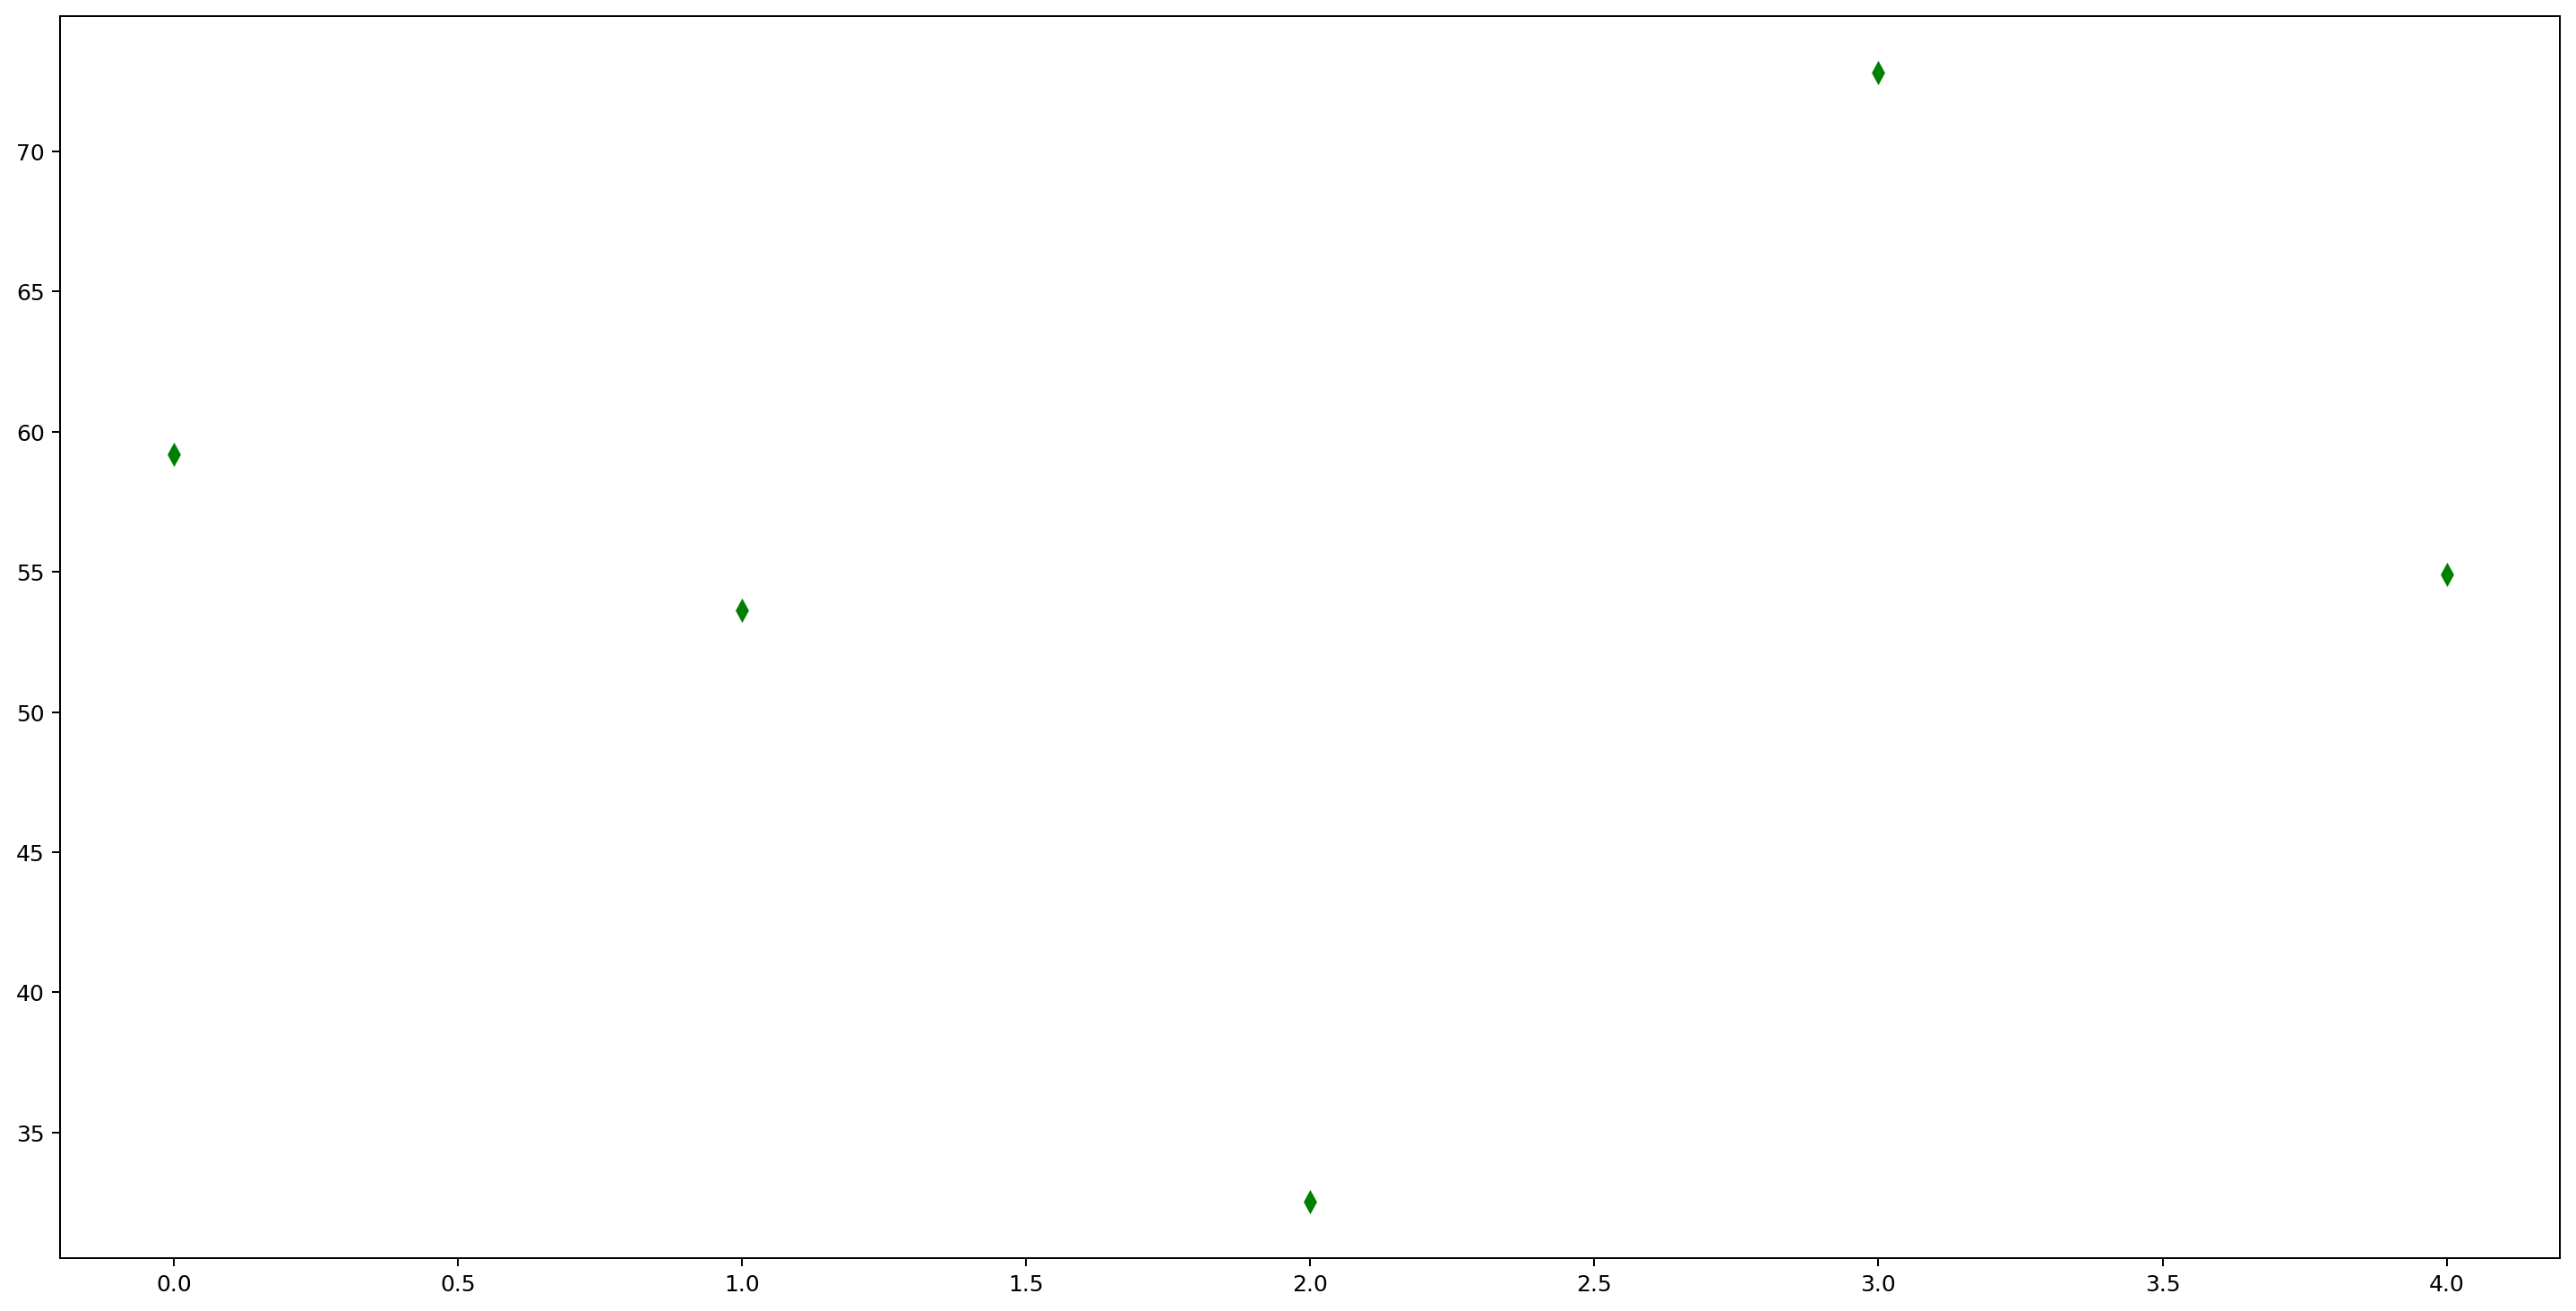

In [147]:
plt.figure()
plt.figure(figsize=(20,10),dpi=180)
plt.plot(bst_mdls['Gauss_model'].predict(X_val)[:5], 'gd', label='Gauss')
# plt.plot(y_val[:5], 'ro', label='target')

In [170]:
df_val = pd.DataFrame()
df_val['target'] = y_val.values
scores = {}
TabNet_model = bst_mdls.pop('TabNet_model')
for el in bst_mdls:
   y_pred = bst_mdls[el].predict(X_val)
   df_val[el] = y_pred
   scores[el] = mean_squared_error(y_true=y_val, y_pred=y_pred, squared=False)

target_sc = StandardScaler()
target_sc.fit(y_train.values.reshape(-1, 1))
# y_val_ = target_sc.fit_transform(y_val.values.reshape(-1, 1))
preds = TabNet_model.predict(X_val)
y_pred = target_sc.inverse_transform(np.array(preds).reshape(-1,1))
scores['TabNetmodel'] = mean_squared_error(y_true=y_val, y_pred=y_pred, squared=False)
bst_mdls['TabNet_model'] = TabNet_model
scores = {k: v for k, v in sorted(scores.items(), key=lambda item: item[1])}
scores

{'Gauss_model': 2.830486298121181,
 'LGBM_model': 8.833172776550544,
 'XGB_model': 9.863851,
 'SVM_model': 11.250518677038638,
 'GB_model': 11.384317602990752,
 'Catboost_model': 11.912399719046102,
 'TabNetmodel': 13.156058,
 'Elastic_model': 14.720053009304575,
 'KNN_model': 15.234,
 'MLP_model': 17.927011236324955,
 'RF_model': 17.935909045487136}

In [224]:
n = 10
y_pred = df_val['Catboost_model'][0:n]
y_true = y_val[0:n]
print(mean_squared_error(y_true, y_pred, squared=False))
print(y_pred.values - y_true.values)
print((y_pred.values - y_true.values)**2)
print(((y_pred.values - y_true.values)**2).mean())

14.16536812356655
[  1.05048083 -11.87889914   7.62890829 -21.10143781  -8.65239547
   2.32925697   3.60474759   6.11444797 -20.39049125  28.53859963]
[  1.10350997 141.10824476  58.20024167 445.27067758  74.86394737
   5.42543803  12.99420519  37.38647403 415.77213343 814.45166872]
200.65765407615532


In [219]:
y_pred

0    59.195956
1    53.618052
2    32.540956
3    72.833414
4    54.910996
5    52.676766
6    33.089614
7    30.950257
8    64.007432
9    31.122669
Name: Gauss_model, dtype: float64

In [220]:
y_true

1072    61.281250
292     58.687500
2239    29.625000
509     78.187500
642     56.937500
2336    54.312500
48      30.984375
305     28.218750
1525    65.312500
1256    25.546875
Name: target_reg, dtype: float16

In [172]:
df_val.head()

,target,Catboost_model,LGBM_model,KNN_model,Elastic_model,GB_model,RF_model,Gauss_model,SVM_model,MLP_model,XGB_model
0,61.28125,62.331731,72.886961,53.56250,61.399613,69.257314,45.174505,59.195956,70.714191,45.299018,66.325813
1,58.68750,46.808601,49.764157,47.12500,48.996650,47.325586,45.174505,53.618052,50.210728,45.299002,46.998730
2,29.62500,37.253908,33.402990,44.00000,38.696733,35.409003,45.174505,32.540956,40.543586,45.298813,33.699379
3,78.18750,57.086062,65.417046,51.00000,64.148693,65.480476,45.174505,72.833414,58.756258,45.298877,66.222992
4,56.93750,48.285105,56.779306,49.59375,53.177945,52.428053,45.174505,54.910996,50.729050,45.298878,56.534443


Для блендинга нам требуется взять 2 бустинга и одну модель не бустинг.

In [207]:
preds = bst_mdls['Gauss_model'].predict(X_sub)

In [208]:
df_sub_c=df_sub[['car_id']]
df_sub_c['target_reg'] = preds
df_sub_c

,car_id,target_reg
0,P17494612l,41.884549
1,N-1530212S,43.470127
2,B-1154399t,37.710315
3,F12725233R,45.404794
4,l-1139189J,44.868426
...,...,...
1908,x13640960Q,55.533036
1909,Z-2276652N,40.635328
1910,F-2165841B,41.465261
1911,x-1331529J,40.742114


In [209]:
df_sub_c.to_csv('ds.csv', index=False)

In [103]:
df_sub_c = df_sub[['car_id',
                 'Catboost_target',
                 'LGBM_target',
                #  'TabNet_target',
                #  'KNN_target',
                #  'Elastic_target',
                #  'RF_target',
                #  'Gaussian_target',
                #  'SVM_target',
                #  'MLP_target'
                 'XGB_target'
]]
df_sub_c.head()

,car_id,Catboost_target,LGBM_target,XGB_target
0,P17494612l,45.850666,52.363799,50.572998
1,N-1530212S,35.679570,38.154592,34.583439
2,B-1154399t,33.962784,27.772626,29.857460
3,F12725233R,35.517209,38.133668,37.600937
4,l-1139189J,35.466363,30.399946,30.309799


In [104]:
scores_mdls_chosen = {}
for i in range(len(df_sub_c.columns)):
    _ = re.sub(r'_target', '_score', df_sub_c.columns[i])
    if _ in mean_scores:
        scores_mdls_chosen.update({_: mean_scores[_]})

scores_mdls_chosen

{'Catboost_score': 12.227562066829494,
 'LGBM_score': 11.906821035762903,
 'XGB_score': 11.797737}

In [ ]:
for el in df_sub_c.columns:
  print(el)

car_id
Catboost_target
LGBM_target
XGB_target


In [ ]:
best_scores_chosen = {}
best_scores_chosen.update({'LGBM_target': mean_scores[el]})

In [ ]:
best_scores_chosen = {}
# for el in df_sub.columns:
#     if el in bst_fold_scores:
#       best_scores_chosen.update({el: bst_fold_scores[el]})

[best_scores_chosen.update({el: bst_fold_scores[el]}) for el in df_sub_c.columns if el in bst_fold_scores]
# best_scores_chosen

scores = 1 / np.array(list(best_scores_chosen.values()))
all_sum = np.sum(scores)
weights_ = scores / all_sum
# weights_

weights = {}
for f, b in zip(best_scores_chosen, weights_):
    weights.update({f: b})
print(weights)

{}

In [ ]:
# for i in best_scores_chosen:
#   print(i)

In [ ]:
def forward(row):
    average = 0
    for el in best_scores_chosen:
       average += row[el] * weights[el]

    return average

df_sub['target_reg'] = df_sub.apply(forward, axis=1)


# weights = [1]
# def forward(row):
#     average = 0
#     for i, el in enumerate(best_scores_chosen):
#         average += row[el] * weights[i]

#     return average

df_sub_c['target_reg'] = df_sub_c.apply(forward, axis=1)
df_sub_c.head()

,car_id,Catboost_target,LGBM_target,XGB_target,target_reg
0,P17494612l,46.275137,52.368682,47.293343,0
1,N-1530212S,35.816005,34.068425,37.522591,0
2,B-1154399t,33.977809,28.749575,32.325630,0
3,F12725233R,34.463048,37.019582,34.500511,0
4,l-1139189J,35.804890,29.944216,35.002319,0


In [ ]:
df_sub_csv = df_sub_c[['car_id', 'target_reg']]
df_sub_csv.to_csv('3_boosters.csv', index=False)

In [ ]:
catboost = 'RMSE вашего решения 11.9. Нужно не более 11.85'
lgbm = 'RMSE вашего решения 12.2. Нужно не более 11.85'
tabnet = 'RMSE вашего решения 13.2. Нужно не более 11.85'
knn = 'RMSE вашего решения 15.0. Нужно не более 11.85'
svm = 'RMSE вашего решения 13.2. Нужно не более 11.85'
xgb = 'RMSE вашего решения 12.2. Нужно не более 11.85'

In [ ]:
TabNet_model LGBM_model Catboost_model KNN_model Elastic_model RF_model Gaussian_model SVM_model MLP_model XGB_model

# Стекинг

In [ ]:
preparing_features(RandomForestRegressor, RandomForestRegressor)

In [ ]:
# ctbrgr = CatBoostRegressor(subsample=0.95,
#                                     min_data_in_leaf=350,
#                                     max_bin=290,
#                                     learning_rate=0.06,
#                                     l2_leaf_reg=2,
#                                     depth=7,
#                            cat_features=cat_features
#                            )
# lgbmrgr = LGBMRegressor(subsample=0.95,
#                         num_leaves=9,
#                         min_data_in_leaf=8,
#                         max_depth=11,
#                         max_bin=60,
#                         lambda_l2=2,
#                         colsample_bytree=0.9
#     )
rfrgr = RandomForestRegressor(n_estimators=512,
                              max_depth=5,
                              max_features='sqrt',
                              random_state=r_s)

preprocessor, pipe = preparing_features(RandomForestRegressor, rfrgr)

In [ ]:
models = [#[ctbrgr, lgbmrgr], # Level 1
          # [rfrgr]
          [pipe]
          ] # Level 2
# models = [[lgbmrgr], # Level 1
#           [rfrgr]] # Level 2

In [ ]:
!git clone https://github.com/nedokormysh/my_pystacknet_corrected
# print(os.listdir("kaggle_pystacknet/pystacknet"))
# !pip install "/content/my_pystacknet_corrected/pystacknet"
!pip install "/content/my_pystacknet_corrected/pystacknet" -q
# import pystacknet

fatal: destination path 'my_pystacknet_corrected' already exists and is not an empty directory.
  Preparing metadata (setup.py) ... done


In [ ]:
import joblib
import sys

sys.modules['sklearn.externals.joblib'] = joblib

from pystacknet.pystacknet import StackNetRegressor

In [ ]:
# Specify parameters for stacked model and begin training
model = StackNetRegressor(models,
                           metric="rmse",
                           folds=4,
                           restacking=False,
                           use_retraining=True,
                          #  use_proba=True, # To use predict_proba after training
                           random_state=0,
                          #  n_jobs=-1,
                           verbose=1)

# Fit the entire model tree
# del models
model

StackNetRegressor(folds=4, metric=<function rmse at 0x79e52c799c60>,
                  models=[[Pipeline(steps=[('feature_preprocessor',
                                            ColumnTransformer(transformers=[('num',
                                                                             Pipeline(steps=[('imputer',
                                                                                              SimpleImputer(strategy='median')),
                                                                                             ('scaler',
                                                                                              StandardScaler())]),
                                                                             ['car_rating',
                                                                              'year_to_start',
                                                                              'riders',
                                                                              'year_to_work',
                                                                              'mean_rating',
                                                                              'distance_sum',
                                                                              'rating_min',
                                                                              'speed_max',
                                                                              'user_ride_quality_median',
                                                                              'user_uniq']),
                                                                            ('cat',
                                                                             Pipeline(steps=[('encoder',
                                                                                              OneHotEncoder(handle_unknown='ignore'))]),
                                                                             ['model',
                                                                              'car_type',
                                                                              'fuel_type'])])),
                                           ('model',
                                            RandomForestRegressor(max_depth=5,
                                                                  max_features='sqrt',
                                                                  n_estimators=512,
                                                                  random_state=7575))])]],
                  random_state=0, verbose=1)

In [ ]:
model.fit(X_train, y_train)

====================== Start of Level 0 ======================
Input Dimensionality 13 at Level 0 
1 models included in Level 0 


ValueError: ignored

In [ ]:
X_train.head()

,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,user_uniq
2131,10,0,0,1.651156,0.569181,0.298614,0.430868,-1.060147,0.106089,-0.237126,0.678064,0.103852,0.118988
2292,14,3,1,0.487187,0.569181,0.702344,0.430868,-1.536201,-0.355484,-0.237126,0.644183,-0.026325,-0.197727
22,14,3,1,0.267718,-0.617417,-0.701867,0.894040,-1.386850,-0.643211,-0.237126,0.621595,1.189970,-0.197727
1092,16,3,1,0.867338,-0.617417,-0.603727,-0.958651,-0.826787,0.407372,-0.237126,0.663006,0.310841,-0.197727
2336,22,1,1,-0.416162,0.569181,0.847479,-0.958651,0.377350,1.467838,1.531285,0.301606,-1.442524,0.435703


In [ ]:
# model.predict(X_sub)

preds = model.predict(X_sub.values)
preds = target_scaler.inverse_transform(np.array(preds).reshape(-1, 1))
preds[:5]

====================== Start of Level 0 ======================
1 estimators included in Level 0 
====================== Start of Level 1 ======================
1 estimators included in Level 1 


array([[42.37205794],
       [34.04430032],
       [33.09762789],
       [33.32164297],
       [33.17605187]])

In [ ]:
df_sub['target_reg'] = preds
# df_sub
# df_sub = df_sub[['car_id', 'target_reg']]
df_sub.to_csv('first_stacked.csv', index=False)

##Simple Stacking

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, StackingClassifier, StackingRegressor
from sklearn.linear_model import LogisticRegression

In [ ]:
TabNet_model LGBM_model Catboost_model KNN_model Elastic_model RF_model Gaussian_model SVM_model MLP_model XGB_model

In [ ]:
# список базовых моделей
estimators = [
    ("SVMoost", bst_mdls['SVM_model']),
    ("LightGBM", bst_mdls['LGBM_model']),
    ("CatBoost", bst_mdls['Catboost_model']),
]

# в качестве мета-модели будем использовать LogisticRegression
meta_model = StackingRegressor(
    estimators=estimators,
    # final_estimator=NuSVR(verbose=False),
    final_estimator=RandomForestRegressor(n_estimators = 10_000,
                                           max_depth = 5,
                                           verbose=False),
    n_jobs=-1,
    verbose=False,
)

stacking_regressor = meta_model
stacking_regressor.fit(X, y)

StackingRegressor(estimators=[('SVMoost',
                               TransformedTargetRegressor(regressor=Pipeline(steps=[('feature_preprocessor',
                                                                                     ColumnTransformer(transformers=[('num',
                                                                                                                      Pipeline(steps=[('imputer',
                                                                                                                                       SimpleImputer(strategy='median')),
                                                                                                                                      ('scaler',
                                                                                                                                       StandardScaler())]),
                                                                                                                      ['car_rating',
                                                                                                                       'year_to_start',
                                                                                                                       'riders',
                                                                                                                       'year_to_work',
                                                                                                                       'mean_rating',
                                                                                                                       'distance_sum',
                                                                                                                       'rating_min',
                                                                                                                       'speed...
                                                          transformer=StandardScaler())),
                              ('CatBoost',
                               TransformedTargetRegressor(regressor=Pipeline(steps=[('feature_preprocessor',
                                                                                     <__main__.CustomTransformer object at 0x79e54b83f640>),
                                                                                    ('model',
                                                                                     <catboost.core.CatBoostRegressor object at 0x79e53ad9b0d0>)]),
                                                          transformer=StandardScaler()))],
                  final_estimator=RandomForestRegressor(max_depth=5,
                                                        n_estimators=10000,
                                                        verbose=False),
                  n_jobs=-1, verbose=False)

In [ ]:
preds = stacking_regressor.predict(X_sub)

In [ ]:
df_sub_st = df_sub[['car_id',]]
df_sub_st['target_reg'] = preds
df_sub_st
df_sub_st.to_csv('stacked_3.csv', index=False)

# Ансамбль.

In [ ]:
!git clone https://github.com/MLWave/Kaggle-Ensemble-Guide

Cloning into 'Kaggle-Ensemble-Guide'...
remote: Enumerating objects: 116, done.
remote: Total 116 (delta 0), reused 0 (delta 0), pack-reused 116
Receiving objects: 100% (116/116), 23.29 KiB | 1.23 MiB/s, done.
Resolving deltas: 100% (53/53), done.


In [ ]:
!python /content/Kaggle-Ensemble-Guide/src/kaggle_vote.py '/content/stacked_*.csv'  '/content/tset.csv'

parsing: /content/stacked_2.csv
parsing: /content/stacked_3.csv
parsing: /content/stacked_1.csv
parsing: /content/stacked_.csv
wrote to /content/tset.csv
